In [1]:
import pandas as pd
import os
import numpy as np
import re
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

### Open the Gathered Data CSV Files

In [2]:
dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }
df = pd.read_csv('../roofline-data.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

In [3]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()

df = df.merge(grouped, on=list(grouped.columns), how='inner')


In [4]:
# NOTE: WE'RE ONLY SHOWING OpenMP Data in the plots below
# the data is technically incomplete, as we had to kill many runs that took too long
# keep only runs that have a targetName that includes '-omp'
#df = df[df['targetName'].str.contains('-omp')]
#df = df[df['targetName'].str.contains('-cuda')]

print(df.shape)
print(df.columns)
print(df.dtypes)

(594, 17)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language               object
dtype: object


### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [5]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

(594, 17)


In [6]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 234
Total unique kernel executions recorded: 552
Number of kernels with no arithmetic intensity (AI) 234 (42.39%)
Number of non-zero AI single-precision kernels recorded: 272 (49.28%)
Number of non-zero AI double-precision kernels recorded: 75 (13.59%)
Number of non-zero Perf single-precision kernels recorded: 272 (49.28%)
Number of non-zero Perf double-precision kernels recorded: 75 (13.59%)
Number of non-zero Perf intop kernels recorded: 551 (99.82%)
Number of non-zero AI intop kernels recorded: 551 (99.82%)


In [7]:

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [8]:
df['dpPerf'] = df['dpPerf']*(1e-11)
df['spPerf'] = df['spPerf']*(1e-11)
df['intPerf'] = df['intPerf']*(1e-11)

### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

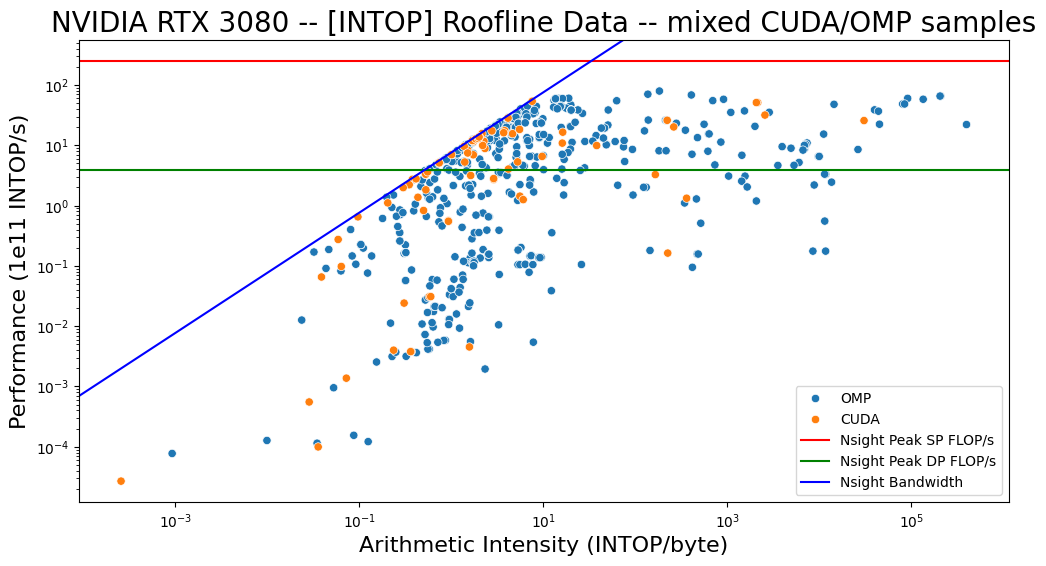

In [9]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)


ax.axhline(249.6,color='red', label='Nsight Peak SP FLOP/s')
ax.axhline(3.9,color='green', label='Nsight Peak DP FLOP/s')

ax.axline(xy1=(0.51,3.9), xy2=(32.94, 249.6), color='blue', label='Nsight Bandwidth')


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('NVIDIA RTX 3080 -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (1e11 INTOP/s)', fontsize=16)

ax.legend()
#ax.legend(['INTOP', 'Nsight SP FLOP Peak Perf.', 'Nsight DP FLOP Peak Perf.', 'Nsight Bandwidth'])

plt.show()

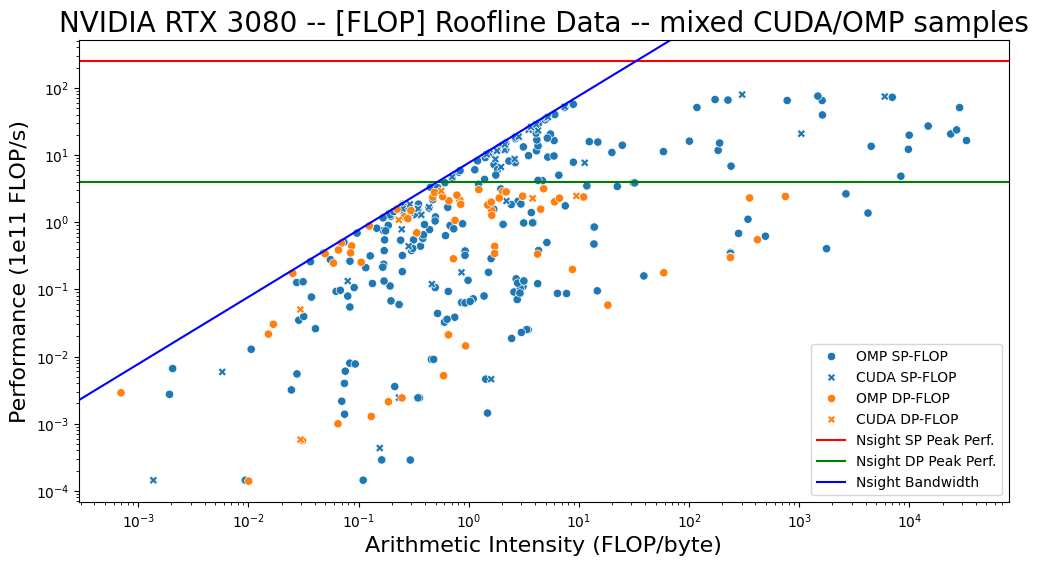

In [10]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')


ax.axhline(249.6,color='red', label='Nsight Peak SP FLOP/s')
ax.axhline(3.9,color='green', label='Nsight Peak DP FLOP/s')

ax.axline(xy1=(0.51,3.9), xy2=(32.94, 249.6), color='blue', label='Nsight Bandwidth')

#ax.plot([0.00001, 32.94], [0.00757, 249.6], color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title('NVIDIA RTX 3080 -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (1e11 FLOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP', 'Nsight SP Peak Perf.', 'Nsight DP Peak Perf.', 'Nsight Bandwidth']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

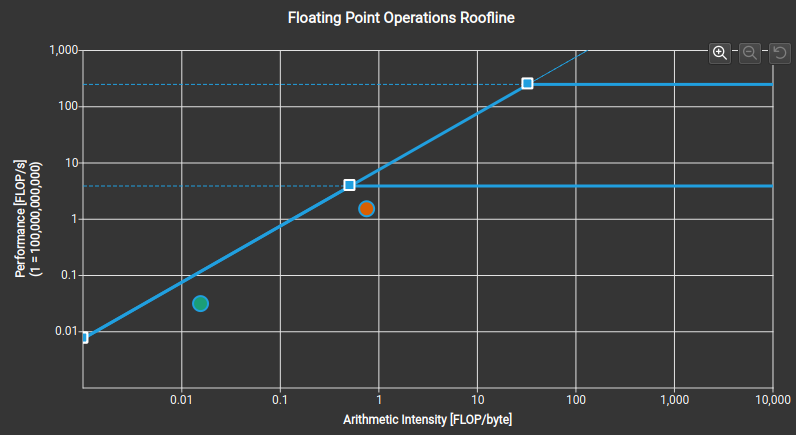

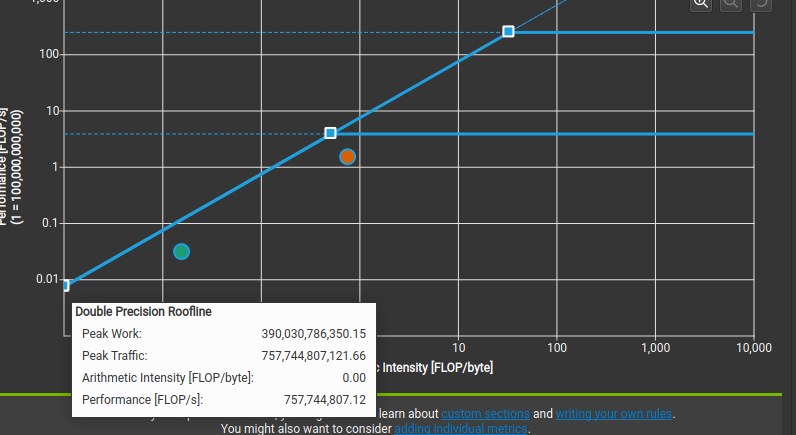

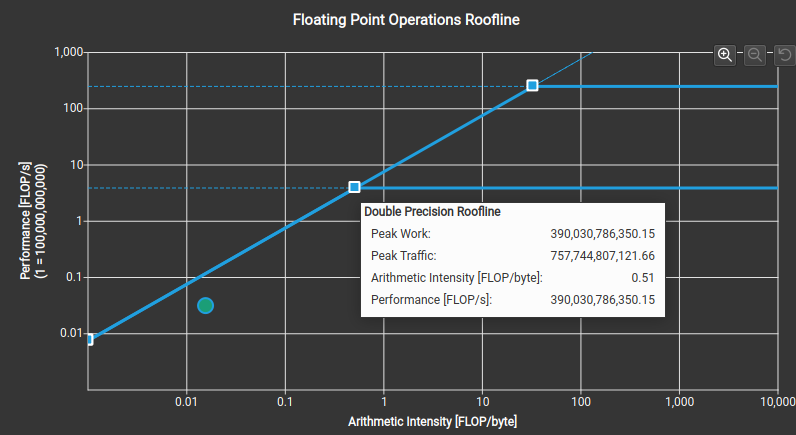

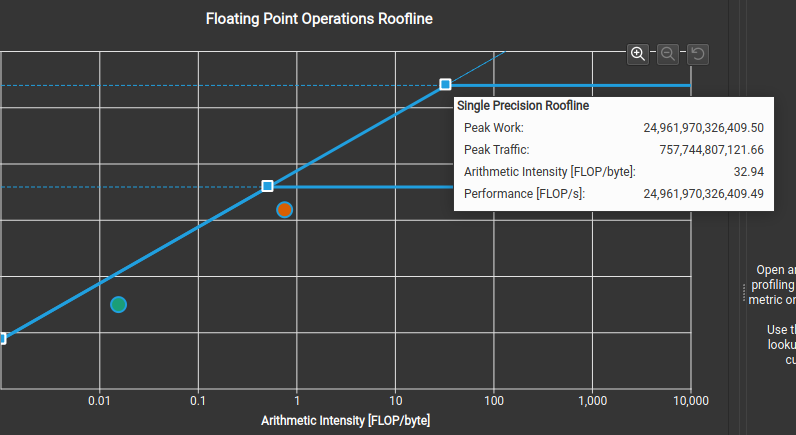

### Let's get some statistics about the data

In [11]:
print(df.columns)


Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')


In [12]:
# how many different kernel invocations did we capture?
totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 234
Total unique kernel executions recorded: 552
Number of kernels with no arithmetic intensity (AI) 234 (42.39%)
Number of non-zero AI single-precision kernels recorded: 272 (49.28%)
Number of non-zero AI double-precision kernels recorded: 75 (13.59%)
Number of non-zero Perf single-precision kernels recorded: 272 (49.28%)
Number of non-zero Perf double-precision kernels recorded: 75 (13.59%)
Number of non-zero Perf intop kernels recorded: 551 (99.82%)
Number of non-zero AI intop kernels recorded: 551 (99.82%)


In [13]:
spData = df[(df['spAI'] > 0)]
dpData = df[(df['dpAI'] > 0)]

#subdata = df[(df['spPerf'] > 0) | (df['dpPerf'] > 0) | (df['spAI'] > 0) | (df['dpAI'] > 0) ]
print('SP data')
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

print()
print('DP data')
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

SP data
spPerf       79.277460
dpPerf        3.140706
spAI      32986.127222
dpAI        748.873518
dtype: float64
spPerf    0.000144
dpPerf    0.000000
spAI      0.001370
dpAI      0.000000
dtype: float64
spPerf    1.196316
dpPerf    0.000000
spAI      1.455780
dpAI      0.000000
dtype: float64
spPerf      7.756059
dpPerf      0.167936
spAI      668.163755
dpAI        5.720432
dtype: float64

DP data
spPerf      29.306288
dpPerf       3.140706
spAI      4498.444386
dpAI       748.873518
dtype: float64
spPerf    0.000000
dpPerf    0.000140
spAI      0.000000
dpAI      0.000697
dtype: float64
spPerf    0.000000
dpPerf    0.875198
spAI      0.000000
dpAI      0.660748
dtype: float64
spPerf     0.782840
dpPerf     1.120237
spAI      63.959725
dpAI      30.578515
dtype: float64


In [27]:

def plotAIHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpAI', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intAI', ax=ax2)
    sns.ecdfplot(subdf, x='spAI', ax=ax2)
    sns.ecdfplot(subdf, x='dpAI', ax=ax2)

    ax.set_xlabel('Arithmetic Intensity (OP/byte -- scaled to 1e11)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'Non-zero Arithmetic Intensity {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

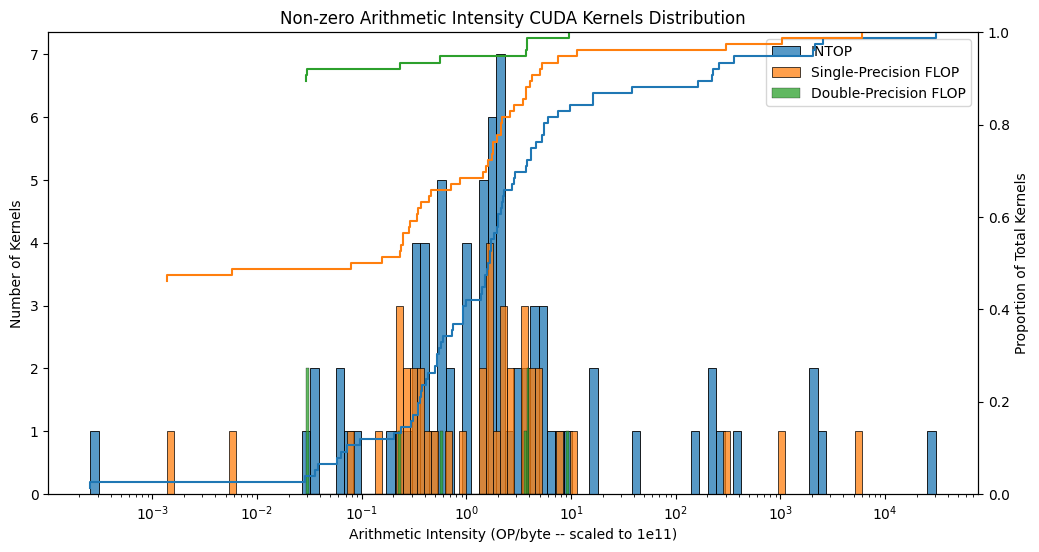

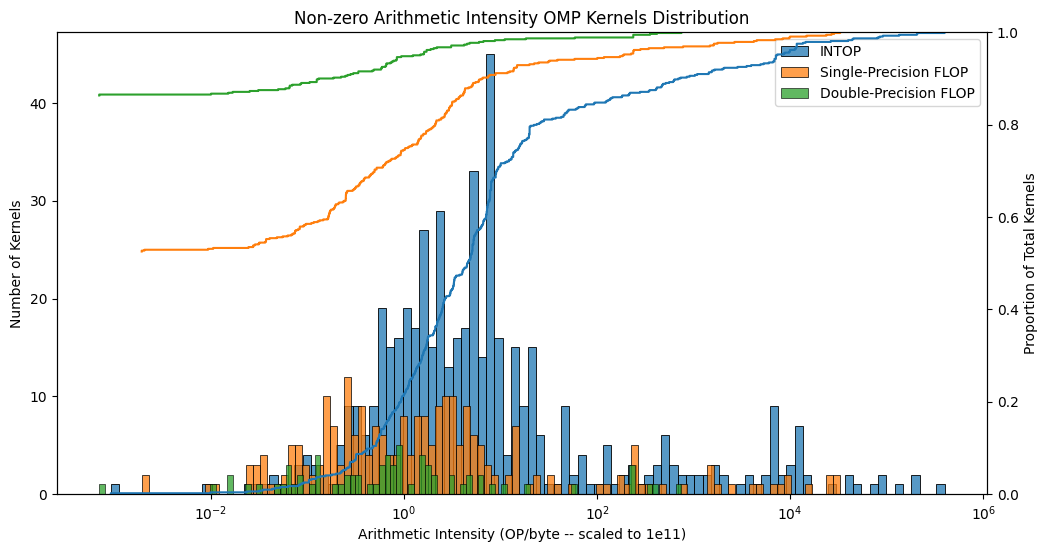

In [34]:
plotAIHistogram(df, 'CUDA')
plotAIHistogram(df, 'OMP')

In [28]:
#subdf = df[df['targetName'].isin(['bspline-vgh-cuda'])].copy().reset_index()
#
#print(subdf)
#
#print(type(subdf.iloc[0]['exeArgs']))
#
#grpA = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs'])
#grpB = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size'])
#
#
#print(grpA)
#print(grpB)
#
#print(grpA.ngroups)
#print(grpB.ngroups)

In [35]:
# what does the AI distribution look like? (violin plot + histogram)

def plotPerfHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpPerf', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intPerf', ax=ax2)
    sns.ecdfplot(subdf, x='spPerf', ax=ax2)
    sns.ecdfplot(subdf, x='dpPerf', ax=ax2)

    ax.set_xlabel('Performance (OP/s -- scaled to 1e11)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'Non-zero Performance {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

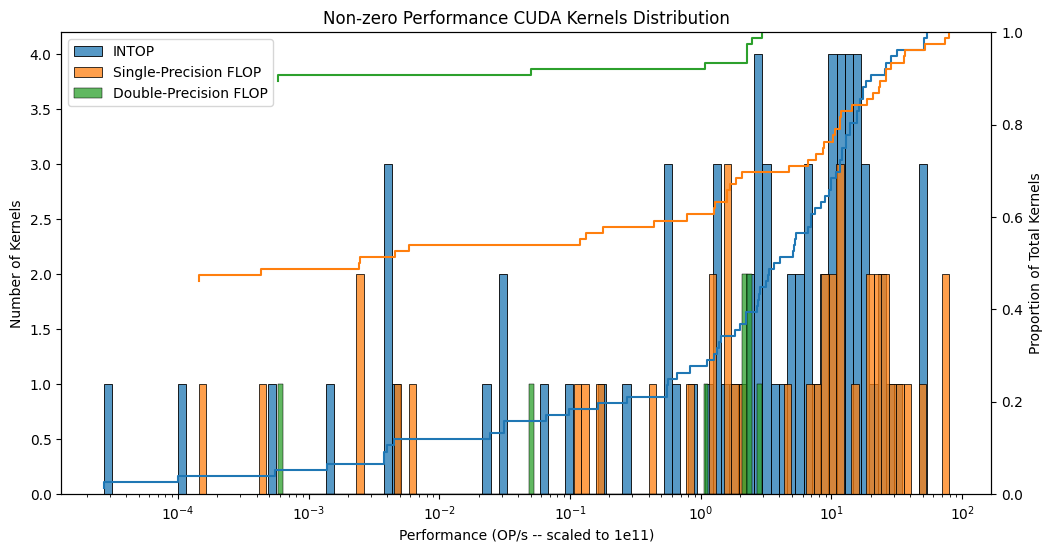

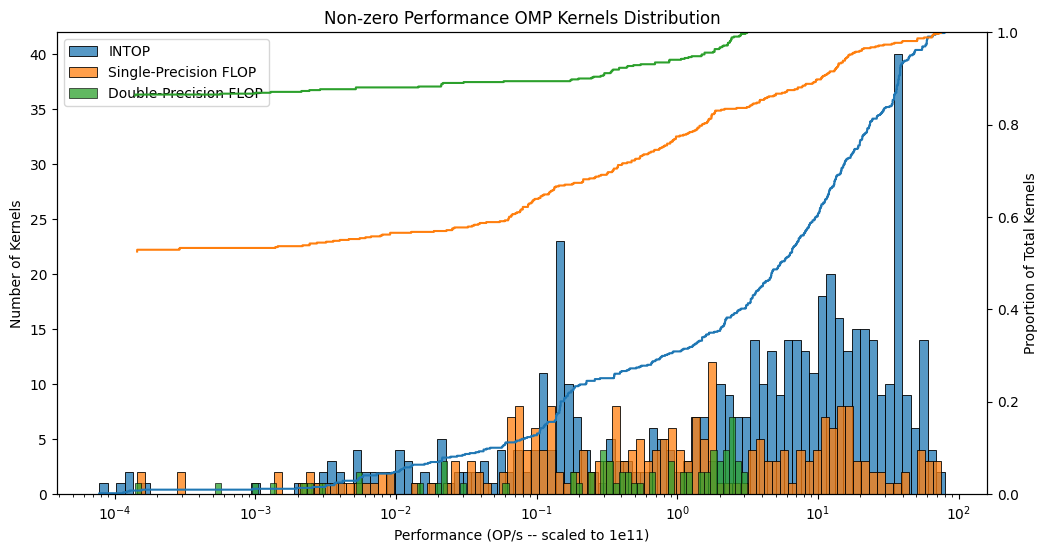

In [36]:
plotPerfHistogram(df, 'CUDA')
plotPerfHistogram(df, 'OMP')

### Visualize the Block and Grid Sizes

In [30]:
# because the sizes are in 3D, let's convert them to 1D by multiplying them


def strTupleTo1D(strTuple):
    finds = re.findall(r'\d+', strTuple)
    nums = [int(find) for find in finds]

    assert len(nums) == 3

    mult = 1
    for num in nums:
        mult = mult*num
    return mult


df['blockSz'] = df['Block Size'].apply(strTupleTo1D).astype(int)
df['gridSz'] = df['Grid Size'].apply(strTupleTo1D).astype(int)

print(df.head())


                                         Kernel Name       traffic  dpAI  \
0  __omp_offloading_10309_2f26c9a__Z6haccmkIfEvim...  2.276443e+07   0.0   
1           __omp_offloading_10309_2fc4a44_main_l156  7.318797e+10   0.0   
2           __omp_offloading_10309_2fc4a44_main_l234  2.799127e+11   0.0   
3           __omp_offloading_10309_2fc4a44_main_l114  6.795699e+08   0.0   
4           __omp_offloading_10309_2fc4a44_main_l267  7.023555e+08   0.0   

          spAI  dpPerf     spPerf      xtime   Block Size       Grid Size  \
0  1769.934277     0.0   0.402915  9924256.0   (32, 1, 1)      (25, 1, 1)   
1     2.799796     0.0   2.049114    25536.0   (32, 1, 1)     (511, 1, 1)   
2     4.120777     0.0  11.534580  1904992.0  (256, 1, 1)  (260100, 1, 1)   
3     0.357571     0.0   0.002430    14880.0   (16, 1, 1)       (1, 1, 1)   
4     0.345302     0.0   0.002425    14944.0   (16, 1, 1)       (1, 1, 1)   

                    device        intops    intPerf       intAI  targetName  \
0

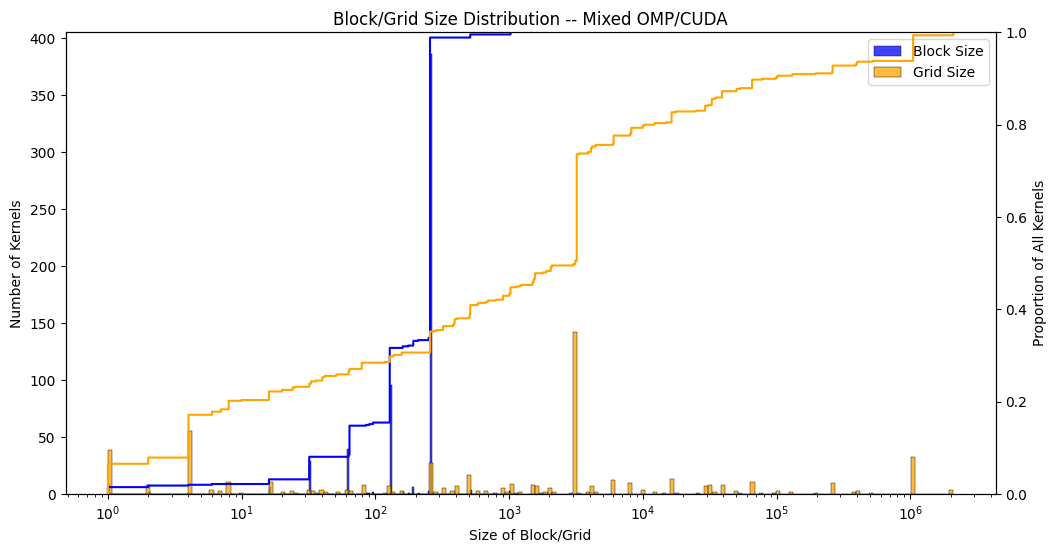

In [38]:

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='blockSz', bins=200, ax=ax, log_scale=True, color='blue')
#sns.histplot(df, x='blockSz', bins=100, ax=ax, log_scale=True, hue='language')
sns.histplot(df, x='gridSz', bins=200, ax=ax, log_scale=True, color='orange')
#sns.histplot(df, x='gridSz', bins=100, ax=ax, log_scale=True, hue='language')
ax2 = ax.twinx()
sns.ecdfplot(df, x='blockSz', ax=ax2, color='blue')
sns.ecdfplot(df, x='gridSz', ax=ax2, color='orange')
#sns.ecdfplot(df, x='blockSz', ax=ax2, hue='language')
#sns.ecdfplot(df, x='gridSz', ax=ax2, hue='language')

ax.set_xlabel('Size of Block/Grid')
ax.set_ylabel('Number of Kernels')
ax2.set_ylabel('Proportion of All Kernels')

ax.set_title('Block/Grid Size Distribution -- Mixed OMP/CUDA')

ax.legend(['Block Size', 'Grid Size'])
#ax2.legend()

plt.show()

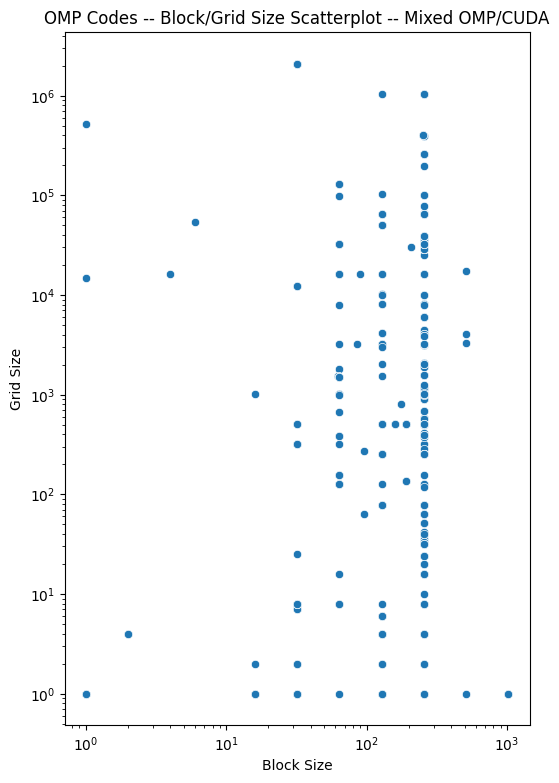

In [37]:

fig, ax = plt.subplots(1, figsize=(6,9))

sns.scatterplot(df, x='blockSz', y='gridSz', ax=ax)

ax.set_title('OMP Codes -- Block/Grid Size Scatterplot -- Mixed OMP/CUDA')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Block Size')
ax.set_ylabel('Grid Size')

plt.show()

In [33]:
uniqBlockSzs = sorted(df['blockSz'].unique().tolist())
print(f'num unique block sizes: {len(uniqBlockSzs)}: {uniqBlockSzs}')

print()
uniqGridSzs = sorted(list(df['gridSz'].unique().tolist()))
print(f'num unique grid  sizes: {len(uniqGridSzs)}: {uniqGridSzs}')

num unique block sizes: 20: [1, 2, 4, 6, 16, 32, 63, 64, 85, 90, 96, 128, 160, 176, 192, 208, 250, 256, 512, 1024]

num unique grid  sizes: 107: [1, 2, 4, 6, 7, 8, 10, 16, 20, 24, 25, 32, 33, 36, 40, 41, 42, 51, 63, 64, 79, 118, 128, 137, 157, 255, 256, 274, 288, 320, 380, 384, 391, 408, 500, 506, 510, 511, 512, 576, 588, 669, 693, 797, 899, 1000, 1017, 1022, 1024, 1130, 1200, 1236, 1500, 1530, 1531, 1563, 1792, 1898, 2048, 2088, 2997, 3062, 3125, 3200, 3328, 3907, 4096, 4168, 4171, 4429, 6000, 6048, 8000, 8160, 8192, 10000, 10240, 12208, 14825, 16384, 17576, 25000, 29184, 30307, 32400, 32768, 34200, 35344, 39063, 50176, 53568, 65536, 66016, 78125, 98304, 100096, 102400, 131072, 195313, 260100, 262144, 390625, 393216, 400000, 524288, 1048576, 2097152]
